Created June 21, 2023

Updated Jun 22, 2023

### Created to plot the results of kmeans grouping the redpy clusters spatially and temporally

Rainier's results for now

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio #rasterio for reading in DEM
from rasterio.plot import show #for plotting with rio
from matplotlib.gridspec import GridSpec
import math
import h5py

In [22]:
#pull in cop-kmeans results (code currently on laptop which has the cop kmeans package installed)
kmeans_filename = 'k_6_cl_grps.csv'
k = int(kmeans_filename.split('_')[1]) #get k from filename
cl_k_grp = pd.read_csv(f'/home/smocz/expand_redpy_new_files/cop_kmeans/{kmeans_filename}')
#pull in cluster locations
locs = pd.read_csv('/home/smocz/expand_redpy_new_files/locations/Rainier_Template_Locations.csv')
#pull in event catalog
Rainier = pd.read_csv('/home/smocz/expand_redpy/csv_catalogs/Rainier_catalog.csv')
#set station to look at waveforms from
sta = 'rcm' #must be lowercase
#pull volcano metadata for station location
volc_md = pd.read_csv('/home/smocz/expand_redpy/csv_catalogs/Volcano_Metadata.csv')
sta_lat = volc_md[volc_md["Station"]==sta.upper()]["Latitude"].values.tolist()[0]
sta_lon = volc_md[volc_md["Station"]==sta.upper()]["Longitude"].values.tolist()[0]
print(sta,sta_lat,sta_lon)

rcm 46.83564 -121.732979


In [23]:
#pull in waveforms
with h5py.File("/home/smocz/expand_redpy_new_files/h5/new_Rainier_template_waveforms.h5", "r") as f: #pull in fingerprints
    fingerprints = f["fingerprints"][()]
    template_name = f["template_name"][()]
#     group_id = f["group_id"][()]
    waveforms = f["waveforms"][()]
    print(f.keys()) #print what data is in this file

<KeysViewHDF5 ['fingerprints', 'template_name', 'waveforms']>


### Location (DEM)

In [24]:
#get locations of clusters
cl_list = [] #will be a list of all clusters with locations
kmeans_grp = [] #will be a list of the kmeans group for each cluster saved
lats = [] #will be a list of all latitude points (indexes match with cl_list)
lons = [] #will be a list of all longitude points (indexes match with cl_list)
for cc,cl in enumerate(cl_k_grp['cluster_id'].values.tolist()):
#     print('---')
#     print('cl',int(cl[2:-1]))
    try:
        lat = locs[locs["Cluster_ID"]==int(cl[2:-1])]["Latitude"].item() #get the associated latitude
        lats.append(lat) #append
        lon = locs[locs["Cluster_ID"]==int(cl[2:-1])]["Longitude"].item() #get the associated longitude
        lons.append(lon) #append
        cl_list.append(cl[2:-1]) #append cl id
        kmeans_grp.append(cl_k_grp['kmeans_grp'].values.tolist()[cc]) #append kmeans id
#         print(lat,lon)
    except:
#         print('no location')
        continue

locdf = pd.DataFrame({"cluster_id":cl_list,"kmeans_grp":kmeans_grp,"latitude":lats,"longitude":lons}) #create df
locdf.head()

,cluster_id,kmeans_grp,latitude,longitude
0,000,1,46.876833,-121.803490
1,001,1,46.856457,-121.751141
2,002,5,46.737305,-121.764939
3,003,2,46.888196,-121.859197
4,004,5,46.847414,-121.734806


Plot locations on DEM

In [25]:
#set up info for DEM plot
dem = rio.open("/home/smocz/expand_redpy_new_files/DEM_data/Rainier_bigger.tif") #open tif file with rio
dem_array = dem.read(1).astype('float64') #set array for DEM
crs = dem.crs #get crs (coordinate reference systems)
dem_data_dict={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1],
               'top':dem.bounds[3]} #extract boundaries
#set volcano center
center_lat = 46.8528857
center_lon = -121.7603744

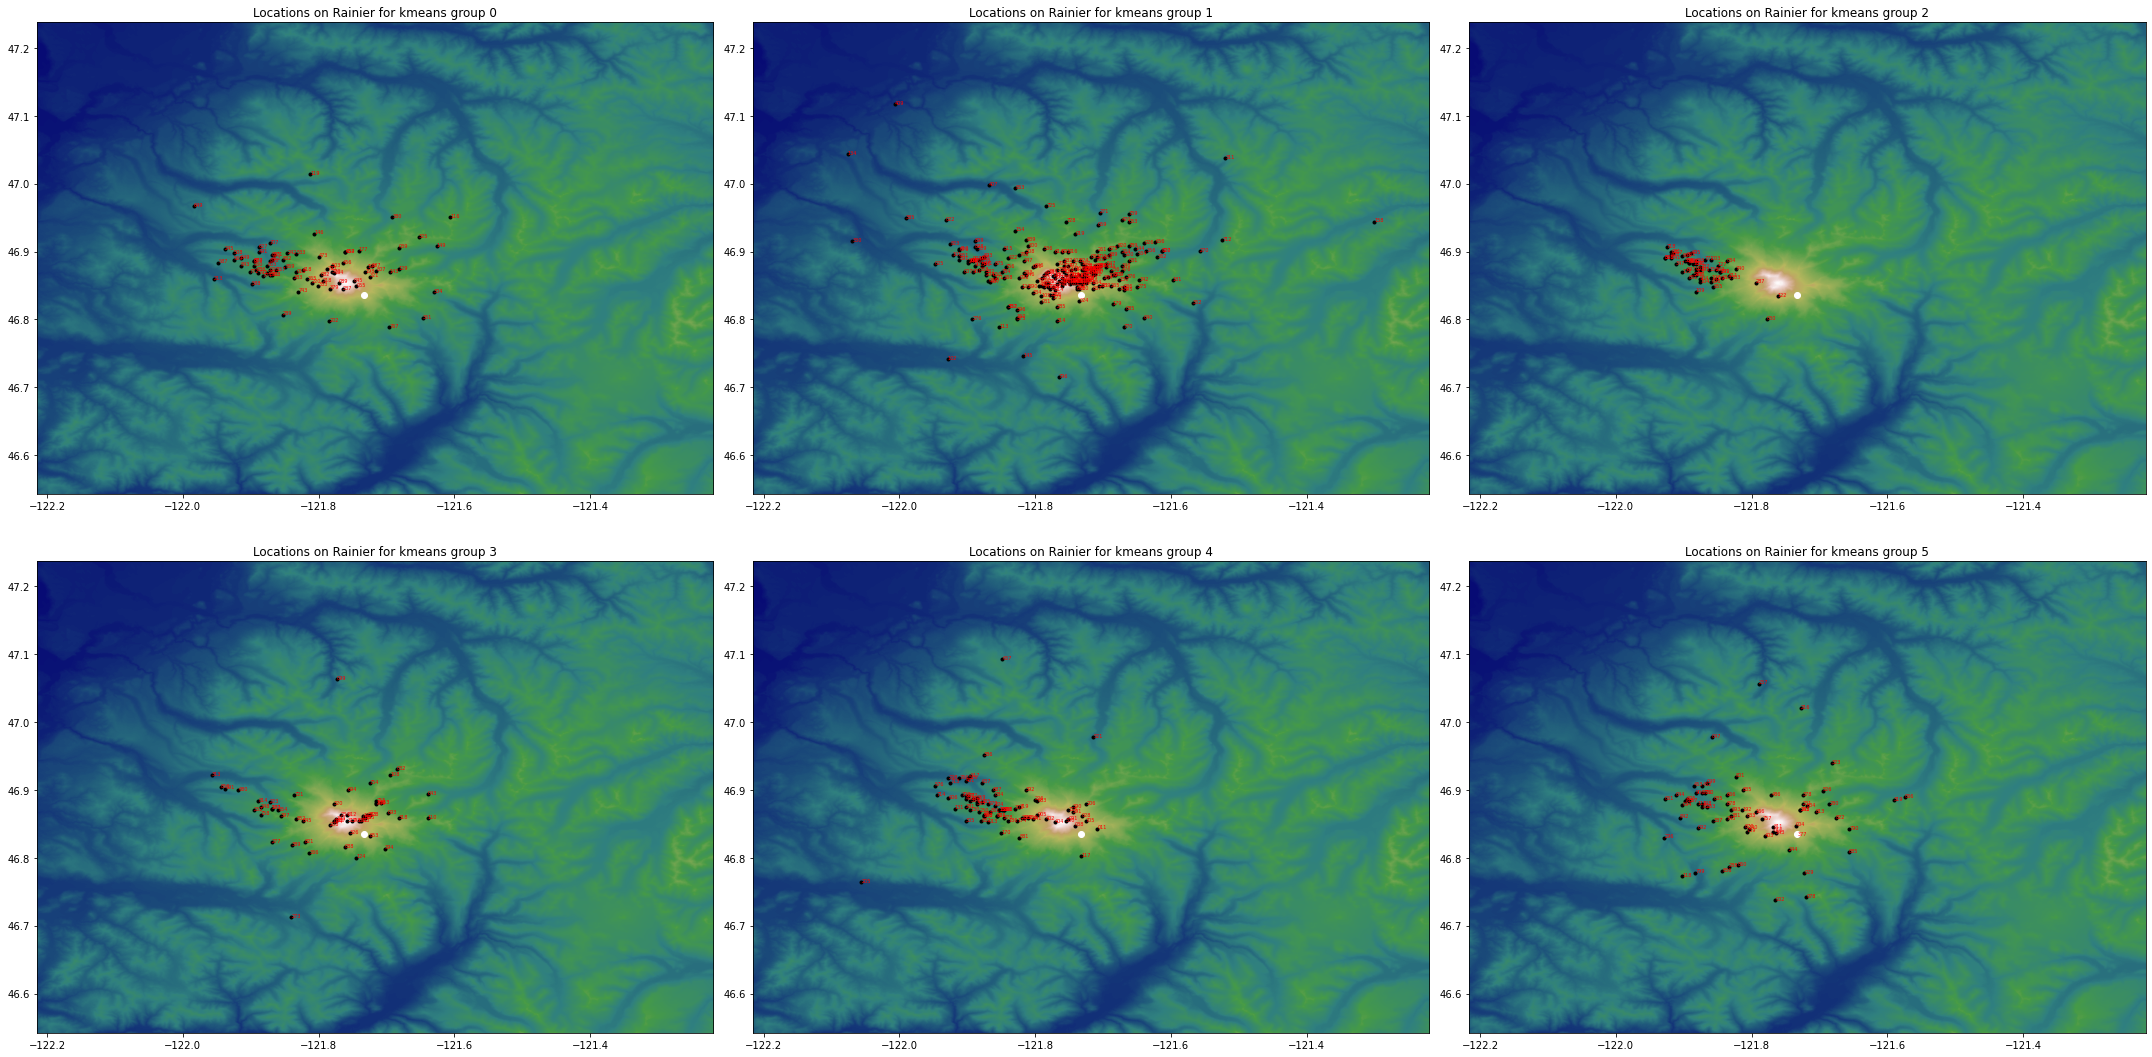

In [26]:
data = dem_data_dict['data']
left,right,bottom,top = dem_data_dict['left'],dem_data_dict['right'],\
                        dem_data_dict['bottom'],dem_data_dict['top']


ncols = 3 #number of columns, stays consistent
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*10,nrows*8))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.set_tight_layout(True)

for aa in range(0,k):#for each subplot
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1, \
            aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    
    ax.imshow(data,extent=[left, right, bottom, top],cmap='gist_earth') #plot DEM
    ax.set_title(f'Locations on Rainier for kmeans group {aa}') #title
    lons = locdf[locdf['kmeans_grp']==aa]['longitude'].values.tolist()
    lats = locdf[locdf['kmeans_grp']==aa]['latitude'].values.tolist()
    ax.scatter(lons,lats,marker='.',color='k',label='Cluster Locations') #plotting some points

    ax.scatter(sta_lon,sta_lat,marker='o',color="white",label=f"station {sta.upper()}")
    
    for point,name in zip([(i,ii) for i,ii in zip(lons,lats)], \
                          locdf[locdf['kmeans_grp']==aa]['cluster_id'].values.tolist()):
        ax.annotate(name,xy=point,color='red',size=5)
    
    #crop/zoom-in on map
    ax.set_xlim(left+.7,right-0.7) #set manually to what looks best
    ax.set_ylim(bottom+0.4,top-.15) #set manually to what looks best
fig.delaxes(ax0) #remove unused ax

# fig.savefig(f'/home/smocz/expand_redpy_new_files/cop_kmeans/DEM_loc_{k}_labeled.svg')

### Time (Scatter)

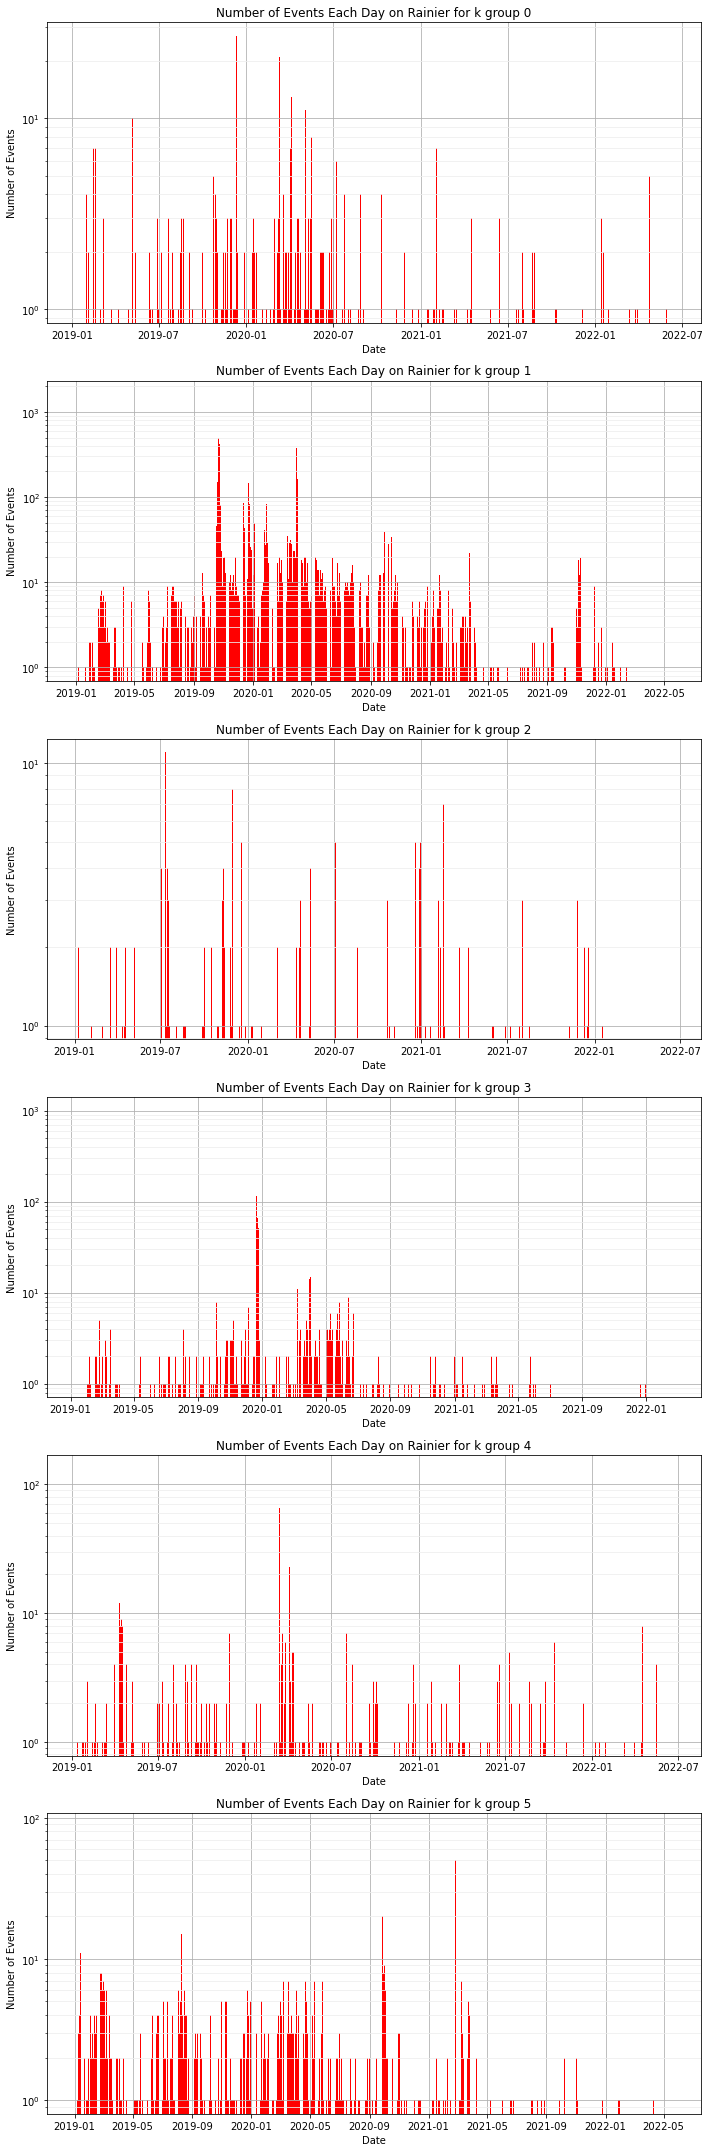

In [27]:
ncols = 1 #number of columns, stays consistent
nrows = math.ceil(k/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*10,nrows*5))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.set_tight_layout(True)

for aa in range(0,k): #for each kmeans group
    
    ### find data for plotting ###
    dt_list = [] #will be a list of all the dates
    
    cl_list = [cl[2:-1] for cl in cl_k_grp[cl_k_grp['kmeans_grp']==aa]['cluster_id'].values.tolist()] #list of cl in kmeans group
    for cl in cl_list: #for each cluster in that group
        d_list = [d[:10] for d in Rainier[Rainier['Clustered']==int(cl)]['datetime'].values.tolist()] #list of dates

        [dt_list.append(d) for d in d_list] #append to overall list
    num_list = [dt_list.count(i) for i in np.unique(dt_list)] #count how many instances of a date appear in dt_list
    
    df = pd.DataFrame({"date":np.unique(dt_list),"number_events":num_list})
    
    ### plot ###
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1, \
            aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    x = pd.to_datetime([str(i) for i in df['date'].values.tolist()]) #read dates as string to pd datetime
    y = df['number_events'].values.tolist() #number of events per day, same index as date list(x)
    
    ax.grid(which='major')
    ax.grid(which='minor',color='#EEEEEE')

    ax.bar(x,y,label='REDPy Events', color='red') #s=40,alpha=0.75,marker='.',


    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Events')
    ax.set_yscale('log')
    ax.set_title(f'Number of Events Each Day on Rainier for k group {aa}')
    
fig.delaxes(ax0) #remove unused ax

# fig.savefig(f'/home/smocz/expand_redpy_new_files/cop_kmeans/time_{k}.svg')

### Waveforms

In [28]:
#get dataframe with template names (cluster) and waveform and kmeans group at one station
templates = []
waves = []
for tname in template_name: #for each template name
    if str(tname)[2:-1].startswith(sta):
        idx = list(template_name).index(tname)
        t_wave = waveforms[idx]
        templates.append(str(tname)[2:-1])
        waves.append(t_wave)
k_grps = []
for t in templates:
    #find which cluster it belongs to, and which kmeans group that belongs to
    kn = cl_k_grp[cl_k_grp["cluster_id"]==(f'b\'{t[-3:]}\'')]["kmeans_grp"].values.tolist()
    k_grps.append(kn[0])
wdf = pd.DataFrame({"template_name":list(templates),"wave":list(waves),"kmeans":k_grps})
wdf.head()

,template_name,wave,kmeans
0,rcmhhzrpra000,"[1.706719391720735, 2.1072614291895184, 1.8612...",1
1,rcmhhzrpra001,"[-2.075366175415957, 2.531869744151012, 4.2914...",1
2,rcmhhzrpra002,"[-0.34575454095498487, -0.733374975345452, -0....",5
3,rcmhhzrpra003,"[-2.8484075698249303, -4.078504865884601, -5.4...",2
4,rcmhhzrpra004,"[-0.22583640882683498, 4.1090049945506975, 7.2...",5


number of clusters = 6
41 waveforms, 175 waveforms, 25 waveforms, 50 waveforms, 43 waveforms, 33 waveforms, showing plot...


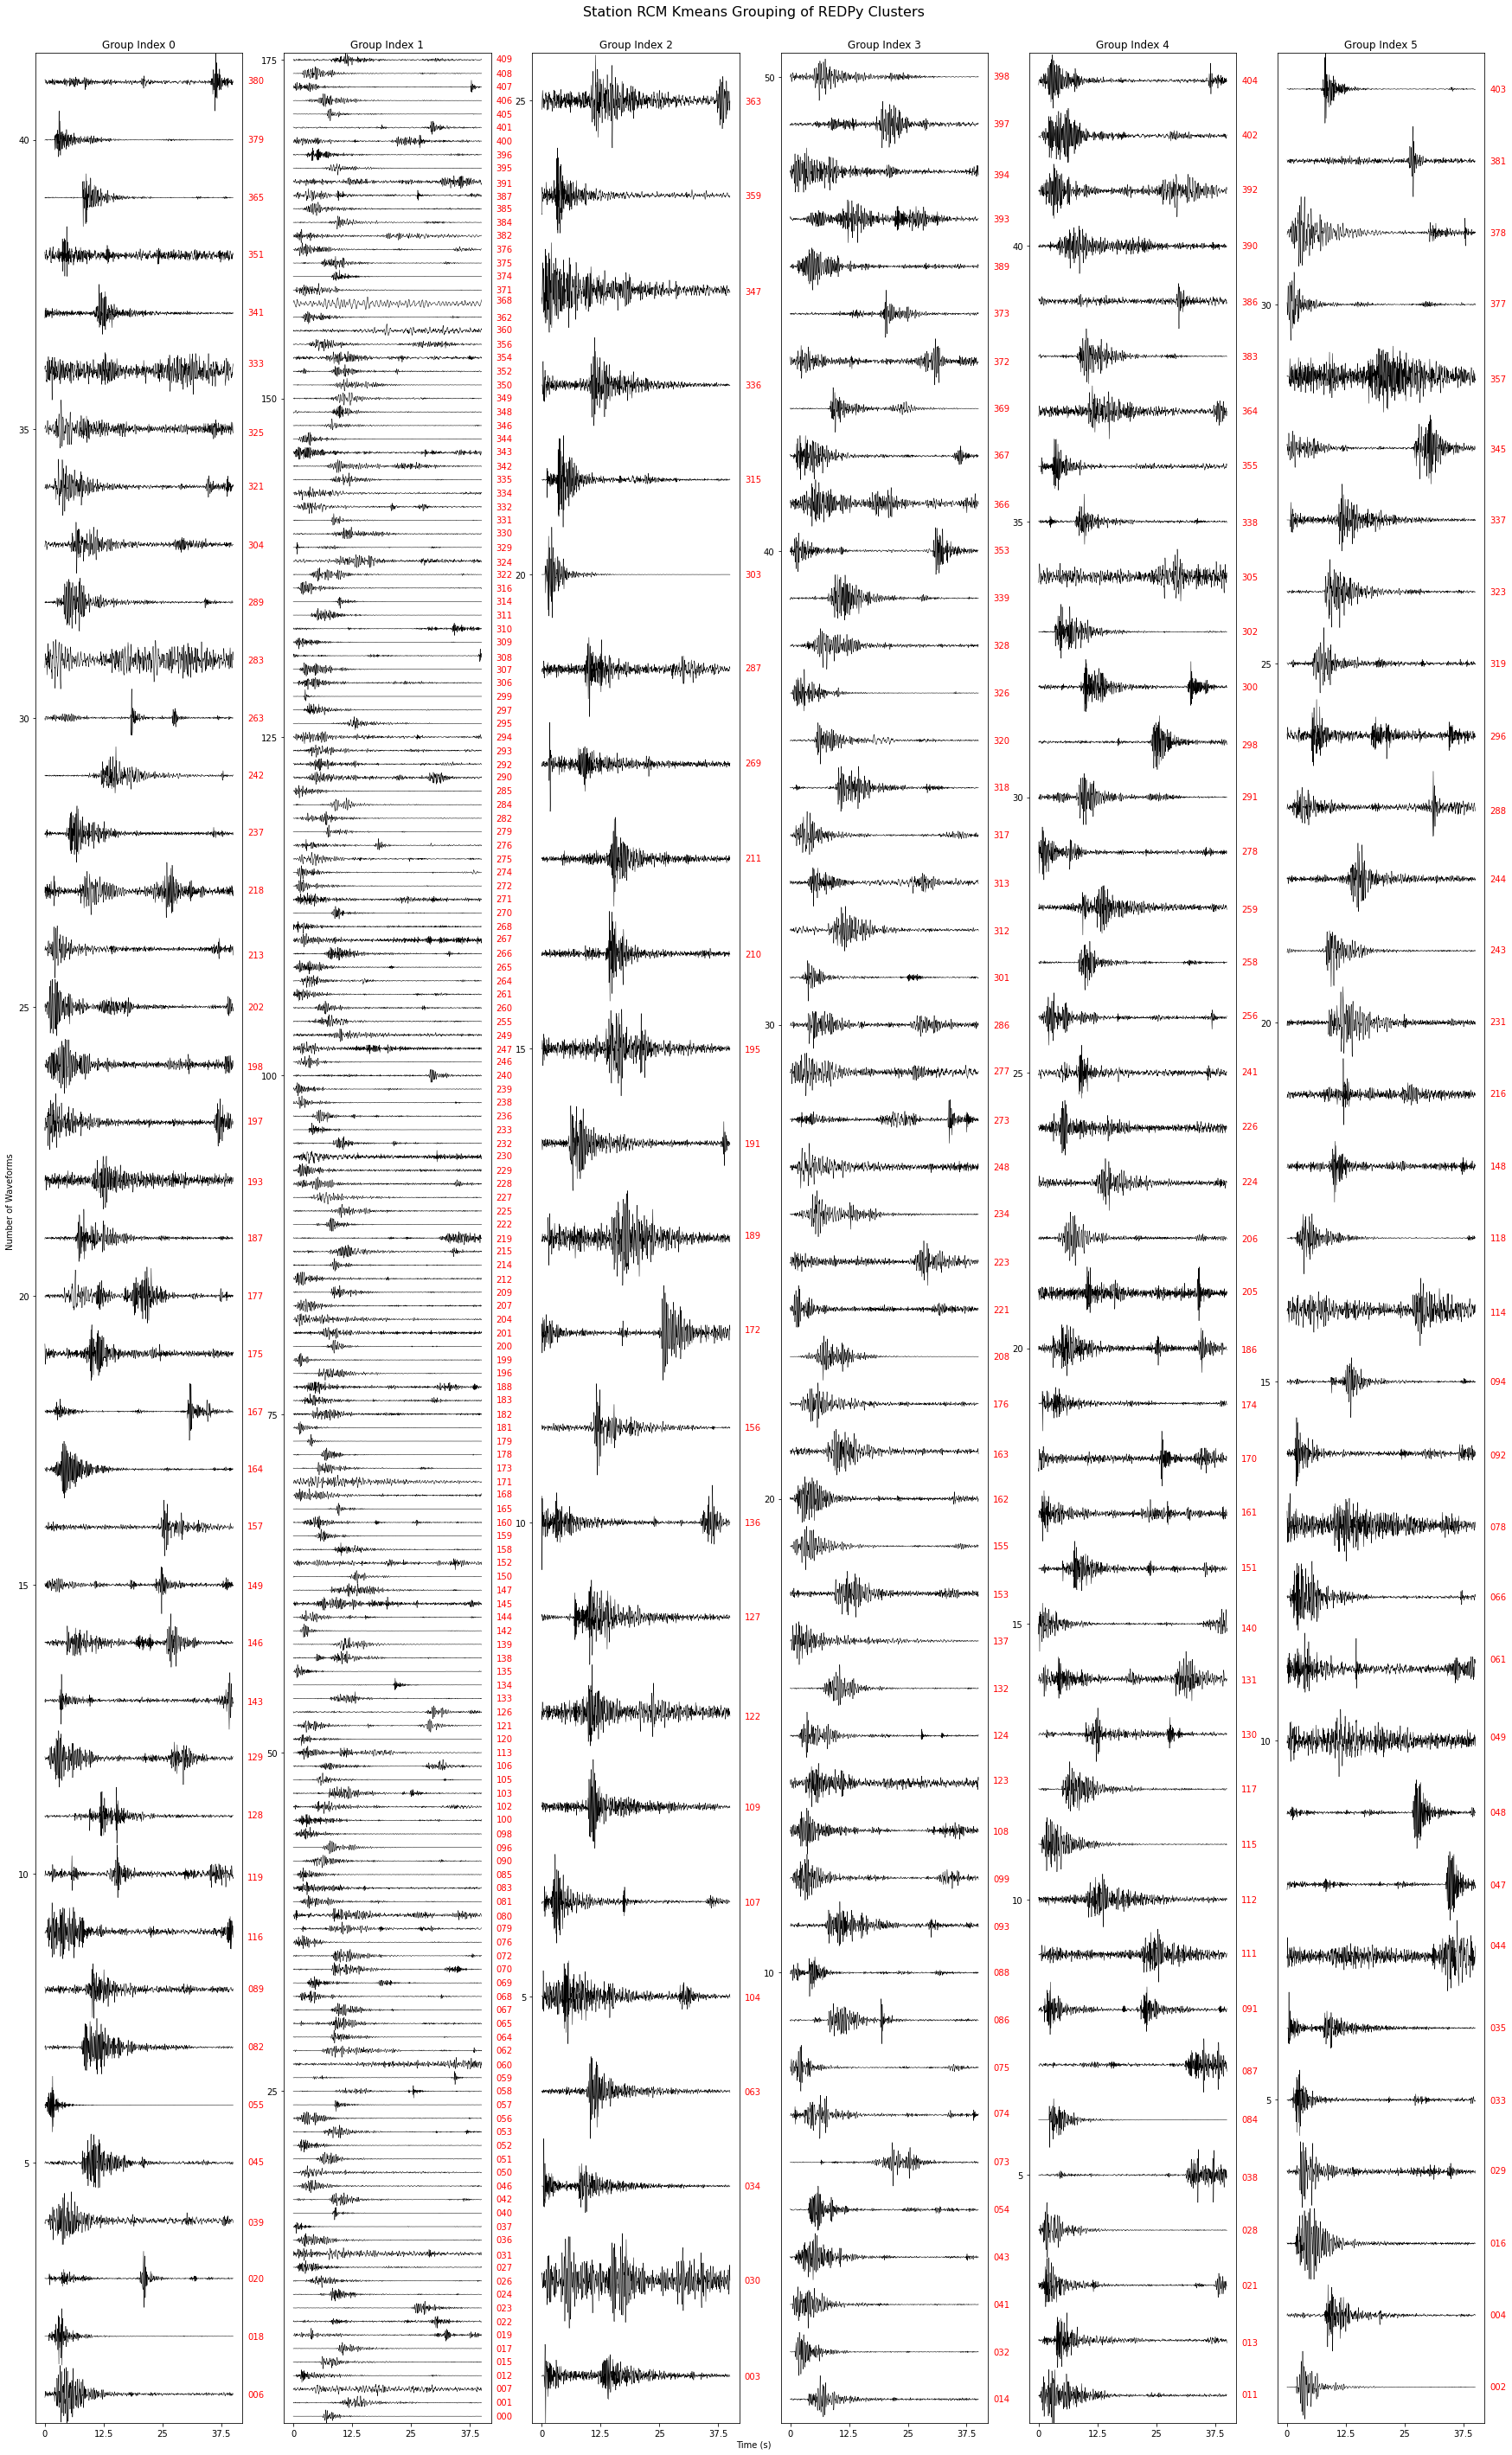

In [33]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import math
from obspy import Trace

print('number of clusters =',k)

ax_list = np.arange(0,k,1) #list of groups, can do np.arange(0,n_clusters,1), do not need to be int

ncols = 6 #number of columns, stays consistent
nrows = math.ceil(len(ax_list)/ncols) #determines number of rows needed by rounding up to nearest whole number

fig, ax0 = plt.subplots(figsize=(ncols*4,nrows*40))
gs = GridSpec(nrows, ncols, figure=fig) #make GridSpec for formatting subplots, based on ncols and nrows
fig.suptitle(f'Station {sta.upper()} Kmeans Grouping of REDPy Clusters',fontsize=16)
# fig.set_tight_layout(True)
fig.tight_layout(rect=[0, 0, 1, 0.975])


for aa,ax_n in enumerate(ax_list):#for each subplot
#     print(f'----{ax_n}----')
    ax = fig.add_subplot(gs[math.floor(aa/ncols):math.floor(aa/ncols)+1,aa - math.floor(aa/ncols)*ncols:aa - math.floor(aa/ncols)*ncols +1]) #add subplot
    ax.set_title(f'Group Index {ax_n}') #label
    
    
    wave_list = [Trace(i) for i in wdf[wdf['kmeans']==aa]['wave'].values.tolist()] #list of waveforms for a Kmeans group
    name_list = [i[-3:] for i in wdf[wdf['kmeans']==aa]['template_name'].values.tolist()] #list of names for a Kmeans group

    print(len(wave_list),'waveforms', end=', ')
    
    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(wave_list):
        ax.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        
    for line, name in zip(ax.lines, name_list): #label each waveform with the cluster id
        y = line.get_ydata()[-1] #find the y value where the line ends
        ax.annotate(name, xy=(1,y), xytext=(6,0), color='red', 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=10, va="center")
    
    x = np.arange(0,len(wave.data),1) #get np array of x points
    xscale = 40 #samling rate in hz
    ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/xscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.xaxis.set_major_formatter(ticks) #set ticks
#     ax.set_xlabel('Time (s)')
    
    y = np.arange(1,len(wave_list),1) #get np array of y points
    #yscale defined above
    ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/yscale)) #set ticks in seconds instead of samples, 40 is sampling rate
    ax.yaxis.set_major_formatter(ticks) #set ticks
    ax.set_ylim(1,(len(wave_list)*yscale)+(.5*yscale))
#     ax.set_ylabel('Number of Waveforms')
    
fig.delaxes(ax0) #remove unused ax
fig.text(0.5, 0.0, 'Time (s)', ha='center')
fig.text(0.0, 0.5, 'Number of Waveforms', va='center', rotation='vertical')

print('showing plot...')

# fig.savefig(f'/home/smocz/expand_redpy_new_files/cop_kmeans/waveforms_{k}.svg')